In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Fuctions

In [ ]:
def crossMat(a):
    """
    Returns the cross product matrix of vector 'a'.

    Parameters:
    a : np.ndarray
        A 3-element array representing a vector.

    Returns:
    A : np.ndarray
        The cross product matrix corresponding to vector 'a'.
    """
    A = np.array([[0, -a[2], a[1]],
                  [a[2], 0, -a[0]],
                  [-a[1], a[0], 0]])

    return A

In [ ]:
def gradEb(xkm1, ykm1, xk, yk, xkp1, ykp1, curvature0, l_k, EI):
    """
    Returns the derivative of bending energy E_k^b with respect to
    x_{k-1}, y_{k-1}, x_k, y_k, x_{k+1}, and y_{k+1}.
    """

    # Nodes in 3D
    node0 = np.array([xkm1, ykm1, 0.0])
    node1 = np.array([xk,    yk,    0.0])
    node2 = np.array([xkp1,  ykp1,  0.0])

    # Unit directors (here just z)
    m2e = np.array([0.0, 0.0, 1.0])
    m2f = np.array([0.0, 0.0, 1.0])

    kappaBar = curvature0

    # Initialize gradient of curvature
    gradKappa = np.zeros(6)

    # Edge vectors
    ee = node1 - node0
    ef = node2 - node1

    # Norms of edge vectors
    norm_e = np.linalg.norm(ee)
    norm_f = np.linalg.norm(ef)

    # If any edge is degenerate, no well-defined curvature → return zero
    eps = 1e-12
    if norm_e < eps or norm_f < eps or l_k < eps:
        return np.zeros(6)

    # Unit tangents
    te = ee / norm_e
    tf = ef / norm_f

    # Dot product (clamped) to avoid exactly -1 or +1
    dot_te_tf = np.dot(te, tf)
    dot_clamped = np.clip(dot_te_tf, -1.0 + 1e-6, 1.0 - 1e-6)

    # Curvature binormal using clamped dot
    denom = 1.0 + dot_clamped
    if abs(denom) < 1e-8:
        # Nearly 180° bend → numerically singular, treat curvature as zero
        return np.zeros(6)

    kb = 2.0 * np.cross(te, tf) / denom

    # Use the same clamped dot for chi
    chi = 1.0 + dot_clamped
    if abs(chi) < 1e-8:
        # Same degeneracy as above, just in another form
        return np.zeros(6)

    tilde_t  = (te + tf) / chi
    tilde_d2 = (m2e + m2f) / chi

    # Curvature (only z-component for planar rod)
    kappa1 = kb[2]

    # Gradient of kappa1 with respect to edge vectors
    Dkappa1De = ( -kappa1 * tilde_t + np.cross(tf, tilde_d2) ) / norm_e
    Dkappa1Df = ( -kappa1 * tilde_t - np.cross(te, tilde_d2) ) / norm_f

    # Populate the gradient of kappa
    gradKappa[0:2] = -Dkappa1De[0:2]
    gradKappa[2:4] =  Dkappa1De[0:2] - Dkappa1Df[0:2]
    gradKappa[4:6] =  Dkappa1Df[0:2]

    # Gradient of bending energy
    dkappa = kappa1 - kappaBar
    dF = gradKappa * EI * dkappa / l_k

    return dF

In [ ]:
def gradEs(xk, yk, xkp1, ykp1, l_k, EA):
    """
    Calculate the gradient of the stretching energy with respect to the coordinates.

    Args:
    - xk (float): x coordinate of the current point
    - yk (float): y coordinate of the current point
    - xkp1 (float): x coordinate of the next point
    - ykp1 (float): y coordinate of the next point
    - l_k (float): reference length
    - EA (float): elastic modulus

    Returns:
    - F (np.array): Gradient array
    """
    F = np.zeros(4)
    F[0] = -(1.0 - np.sqrt((xkp1 - xk)**2.0 + (ykp1 - yk)**2.0) / l_k) * ((xkp1 - xk)**2.0 + (ykp1 - yk)**2.0)**(-0.5) / l_k * (-2.0 * xkp1 + 2.0 * xk)
    F[1] = -(0.1e1 - np.sqrt((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k) * ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1) / l_k * (-0.2e1 * ykp1 + 0.2e1 * yk)
    F[2] = -(0.1e1 - np.sqrt((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k) * ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1) / l_k * (0.2e1 * xkp1 - 0.2e1 * xk)
    F[3] = -(0.1e1 - np.sqrt((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k) * ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1) / l_k * (0.2e1 * ykp1 - 0.2e1 * yk)

    F = 0.5 * EA * l_k * F  # Scale by EA and l_k

    return F

In [ ]:
def hessEb(xkm1, ykm1, xk, yk, xkp1, ykp1, curvature0, l_k, EI):
    """
    Returns the Hessian (second derivative) of bending energy E_k^b
    with respect to x_{k-1}, y_{k-1}, x_k, y_k, x_{k+1}, and y_{k+1}.
    """

    # Nodes in 3D
    node0 = np.array([xkm1, ykm1, 0.0])
    node1 = np.array([xk,    yk,    0.0])
    node2 = np.array([xkp1,  ykp1,  0.0])

    # Unit directors along z
    m2e = np.array([0.0, 0.0, 1.0])
    m2f = np.array([0.0, 0.0, 1.0])

    kappaBar = curvature0

    # Edge vectors
    ee = node1 - node0
    ef = node2 - node1

    # Norms of edge vectors
    norm_e = np.linalg.norm(ee)
    norm_f = np.linalg.norm(ef)

    # Degenerate geometry -> no well-defined curvature/Hessian
    eps = 1e-12
    if norm_e < eps or norm_f < eps or l_k < eps:
        return np.zeros((6, 6))

    # Unit tangents
    te = ee / norm_e
    tf = ef / norm_f

    # Clamp dot product to avoid exactly -1 or +1
    dot_te_tf = np.dot(te, tf)
    dot_clamped = np.clip(dot_te_tf, -1.0 + 1e-6, 1.0 - 1e-6)

    # Curvature binormal using clamped dot
    denom = 1.0 + dot_clamped
    if abs(denom) < 1e-8:
        # Nearly 180° bend -> numerically singular
        return np.zeros((6, 6))

    kb = 2.0 * np.cross(te, tf) / denom

    # Use same clamped dot for chi
    chi = 1.0 + dot_clamped
    if abs(chi) < 1e-8:
        return np.zeros((6, 6))

    tilde_t  = (te + tf) / chi
    tilde_d2 = (m2e + m2f) / chi

    # Curvature (z-component)
    kappa1 = kb[2]

    # Gradient of kappa1 wrt edge vectors
    Dkappa1De = ( -kappa1 * tilde_t + np.cross(tf, tilde_d2) ) / norm_e
    Dkappa1Df = ( -kappa1 * tilde_t - np.cross(te, tilde_d2) ) / norm_f

    # Assemble gradKappa (6-vector)
    gradKappa = np.zeros(6)
    gradKappa[0:2] = -Dkappa1De[0:2]
    gradKappa[2:4] =  Dkappa1De[0:2] - Dkappa1Df[0:2]
    gradKappa[4:6] =  Dkappa1Df[0:2]

    # Now the second derivatives of kappa
    DDkappa1 = np.zeros((6, 6))

    norm2_e = norm_e**2
    norm2_f = norm_f**2
    Id3     = np.eye(3)

    tt_o_tt = np.outer(tilde_t, tilde_t)

    tmp = np.cross(tf, tilde_d2)
    tf_c_d2t_o_tt = np.outer(tmp, tilde_t)
    kb_o_d2e      = np.outer(kb, m2e)

    D2kappa1De2 = (
        (2.0 * kappa1 * tt_o_tt - tf_c_d2t_o_tt - tf_c_d2t_o_tt.T) / norm2_e
        - kappa1 / (chi * norm2_e) * (Id3 - np.outer(te, te))
        + (kb_o_d2e + kb_o_d2e.T) / (4.0 * norm2_e)
    )

    tmp = np.cross(te, tilde_d2)
    te_c_d2t_o_tt = np.outer(tmp, tilde_t)
    tt_o_te_c_d2t = te_c_d2t_o_tt.T
    kb_o_d2f      = np.outer(kb, m2f)

    D2kappa1Df2 = (
        (2.0 * kappa1 * tt_o_tt + te_c_d2t_o_tt + te_c_d2t_o_tt.T) / norm2_f
        - kappa1 / (chi * norm2_f) * (Id3 - np.outer(tf, tf))
        + (kb_o_d2f + kb_o_d2f.T) / (4.0 * norm2_f)
    )

    D2kappa1DeDf = (
        -kappa1 / (chi * norm_e * norm_f) * (Id3 + np.outer(te, tf))
        + 1.0 / (norm_e * norm_f)
          * (2.0 * kappa1 * tt_o_tt
             - tf_c_d2t_o_tt
             + tt_o_te_c_d2t
             - crossMat(tilde_d2))
    )
    D2kappa1DfDe = D2kappa1DeDf.T

    # Fill DDkappa1 (only 2D blocks needed)
    DDkappa1[0:2, 0:2] = D2kappa1De2[0:2, 0:2]
    DDkappa1[0:2, 2:4] = -D2kappa1De2[0:2, 0:2] + D2kappa1DeDf[0:2, 0:2]
    DDkappa1[0:2, 4:6] = -D2kappa1DeDf[0:2, 0:2]

    DDkappa1[2:4, 0:2] = -D2kappa1De2[0:2, 0:2] + D2kappa1DfDe[0:2, 0:2]
    DDkappa1[2:4, 2:4] = (
        D2kappa1De2[0:2, 0:2]
        - D2kappa1DeDf[0:2, 0:2]
        - D2kappa1DfDe[0:2, 0:2]
        + D2kappa1Df2[0:2, 0:2]
    )
    DDkappa1[2:4, 4:6] = D2kappa1DeDf[0:2, 0:2] - D2kappa1Df2[0:2, 0:2]

    DDkappa1[4:6, 0:2] = -D2kappa1DfDe[0:2, 0:2]
    DDkappa1[4:6, 2:4] = D2kappa1DfDe[0:2, 0:2] - D2kappa1Df2[0:2, 0:2]
    DDkappa1[4:6, 4:6] = D2kappa1Df2[0:2, 0:2]

    # Hessian of bending energy
    dkappa = kappa1 - kappaBar

    dJ = EI / l_k * np.outer(gradKappa, gradKappa)
    dJ += EI / l_k * dkappa * DDkappa1

    return dJ

In [ ]:
def hessEs(xk, yk, xkp1, ykp1, l_k, EA):
    """
    This function returns the 4x4 Hessian of the stretching energy E_k^s with
    respect to x_k, y_k, x_{k+1}, and y_{k+1}.
    """
    J = np.zeros((4, 4))  # Initialize the Hessian matrix
    J11 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (-2 * xkp1 + 2 * xk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((-2 * xkp1 + 2 * xk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J12 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (-2 * ykp1 + 2 * yk) * (-2 * xkp1 + 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * xkp1 + 2 * xk) * (-2 * ykp1 + 2 * yk) / 0.2e1
    J13 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * xkp1 - 2 * xk) * (-2 * xkp1 + 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * xkp1 + 2 * xk) * (2 * xkp1 - 2 * xk) / 0.2e1 + 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J14 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) * (-2 * xkp1 + 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * xkp1 + 2 * xk) * (2 * ykp1 - 2 * yk) / 0.2e1
    J22 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (-2 * ykp1 + 2 * yk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((-2 * ykp1 + 2 * yk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J23 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * xkp1 - 2 * xk) * (-2 * ykp1 + 2 * yk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * ykp1 + 2 * yk) * (2 * xkp1 - 2 * xk) / 0.2e1
    J24 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) * (-2 * ykp1 + 2 * yk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * ykp1 + 2 * yk) * (2 * ykp1 - 2 * yk) / 0.2e1 + 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J33 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * xkp1 - 2 * xk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((2 * xkp1 - 2 * xk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J34 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) * (2 * xkp1 - 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (2 * xkp1 - 2 * xk) * (2 * ykp1 - 2 * yk) / 0.2e1
    J44 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((2 * ykp1 - 2 * yk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k

    J = np.array([[J11, J12, J13, J14],
                   [J12, J22, J23, J24],
                   [J13, J23, J33, J34],
                   [J14, J24, J34, J44]])

    J *= 0.5 * EA * l_k

    return J

In [ ]:
def getFb(q, EI, deltaL):
  # q - DOF vector of size N
  # EI - bending stiffness
  # deltaL - undeformed Voronoi length (assume to be a scalar for this simple example)
  # Output:
  # Fb - a vector (negative gradient of elastic stretching force)
  # Jb - a matrix (negative hessian of elastic stretching force)

  ndof = q.size # Number of DOFs
  N = ndof // 2 # Number of nodes

  Fb = np.zeros(ndof) # bending force
  Jb = np.zeros((ndof, ndof))

  # First bending spring (USE A LOOP for the general case)
  for k in range(1, N-1):
    xkm1 = q[2*k-2] # x coordinate of the first node
    ykm1 = q[2*k-1] # y coordinate of the first node
    xk = q[2*k] # x coordinate of the second node
    yk = q[2*k+1] # y coordinate of the second node
    xkp1 = q[2*k+2] # x coordinate of the third node
    ykp1 = q[2*k+3] # y coordinate of the third node
    ind = np.arange(2*k-2, 2*k+4)
    gradEnergy = gradEb(xkm1, ykm1, xk, yk, xkp1, ykp1, 0, deltaL, EI)
    hessEnergy = hessEb(xkm1, ykm1, xk, yk, xkp1, ykp1, 0, deltaL, EI)

    Fb[ind] -= gradEnergy # force = - gradient of energy. Fb is the stretching force
    Jb[np.ix_(ind, ind)] -= hessEnergy # index vector: 0:6

  return Fb, Jb

In [ ]:
def getFs(q, EA, deltaL):
  # q - DOF vector of size N
  # EA - stretching stiffness
  # deltaL - undeformed reference length (assume to be a scalar for this simple example)
  # Output:
  # Fs - a vector (negative gradient of elastic stretching force)
  # Js - a matrix (negative hessian of elastic stretching force)

  ndof = q.size # Number of DOFs
  N = ndof // 2 # Number of nodes

  Fs = np.zeros(ndof) # stretching force
  Js = np.zeros((ndof, ndof))

  for k in range(0, N-1):
      # May need to modify if network of beams
      # k-th stretching spring (USE A LOOP for the general case
      xkm1 = q[2*k] # x coordinate of the first node
      ykm1 = q[2*k+1] # y coordinate of the first node
      xk = q[2*k+2] # x coordinate of the second node
      yk = q[2*k+3] # y coordinate of the second node
      ind = np.arange(2*k, 2*k+4) # 0, 1, 2, 3 for k = 0
      gradEnergy = gradEs(xkm1, ykm1, xk, yk, deltaL, EA)
      hessEnergy = hessEs(xkm1, ykm1, xk, yk, deltaL, EA)

      Fs[ind] -= gradEnergy # force = - gradient of energy. Fs is the stretching force
      Js[np.ix_(ind, ind)] -= hessEnergy # index vector: 0:4

  return Fs, Js

In [ ]:
def objfun(q_old, u_old, dt, tol, maximum_iter,
           m, mMat, # inertia
           EI, EA, # elastic stiffness
           W, C, # external force
           deltaL,
           free_index):

  q_new = q_old.copy() # Guess solution

  # Newton Raphson
  iter_count = 0 # number of iterations
  error = tol * 10 # error
  flag = 1 # if flag = 1, it is a good solution

  while error > tol:
    # Inertia
    F_inertia = m/dt * ((q_new - q_old) / dt - u_old)
    J_inertia = mMat / dt ** 2

    # Elastic forces: Stretching and Bending
    Fs, Js = getFs(q_new, EA, deltaL)
    Fb, Jb = getFb(q_new, EI, deltaL)
    F_elastic = Fs + Fb
    J_elastic = Js + Jb

    # External forces
    # Viscous force
    Fv = - C @ ( q_new - q_old ) / dt
    Jv = - C / dt

    # Equations of motion
    f = F_inertia - F_elastic - Fv - W
    J = J_inertia - J_elastic - Jv

    f_free = f[free_index]
    J_free = J[np.ix_(free_index, free_index)]

    # Newton's update (all DOFs are FREE)
    dq_free = np.linalg.solve(J_free, f_free)
    q_new[free_index] = q_new[free_index] - dq_free

    # Get the error
    error = np.linalg.norm(f_free)

    # Update the iteration number
    iter_count += 1
    if iter_count > maximum_iter:
      flag = -1 # Return with an error signal
      print("Maximum number of iterations reached.")
      return q_new, flag

    # u_new = (q_new - q_old) / dt # Velocity
  return q_new, flag

# Main Loops


Running passive simulation for U = 5.0 m/s ...

=== Wind case U = 5.0 m/s ===
Re ≈ 1.021e+05, Cd ≈ 1.20, F_D,total ≈ 110.2 N,  w_dist ≈ 5.5 N/m
Equivalent nodal force per node ≈ 2.2 N

Running passive simulation for U = 10.0 m/s ...

=== Wind case U = 10.0 m/s ===
Re ≈ 2.042e+05, Cd ≈ 1.00, F_D,total ≈ 367.5 N,  w_dist ≈ 18.4 N/m
Equivalent nodal force per node ≈ 7.4 N

Running passive simulation for U = 15.0 m/s ...

=== Wind case U = 15.0 m/s ===
Re ≈ 3.062e+05, Cd ≈ 1.00, F_D,total ≈ 826.9 N,  w_dist ≈ 41.3 N/m
Equivalent nodal force per node ≈ 16.5 N


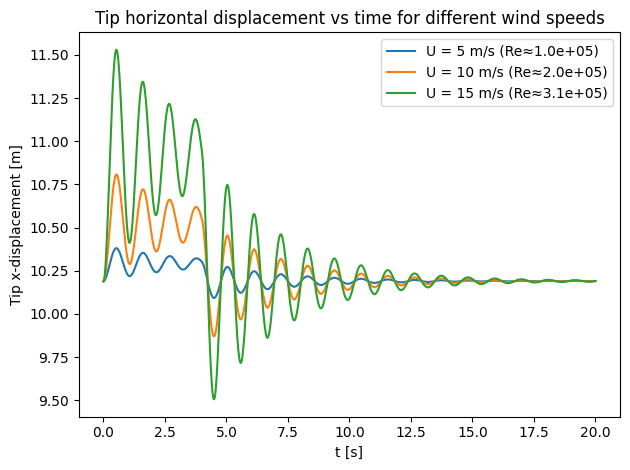

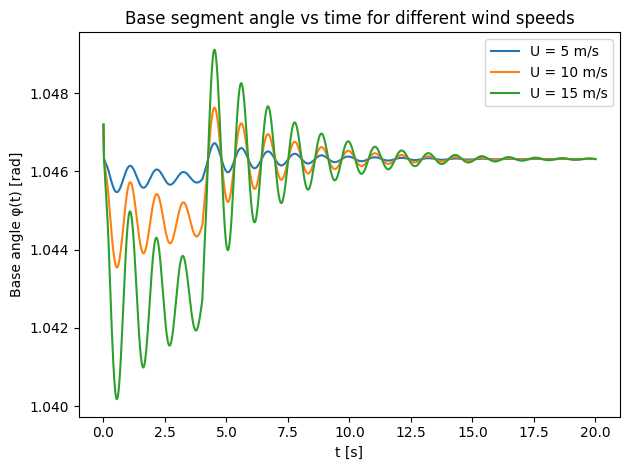

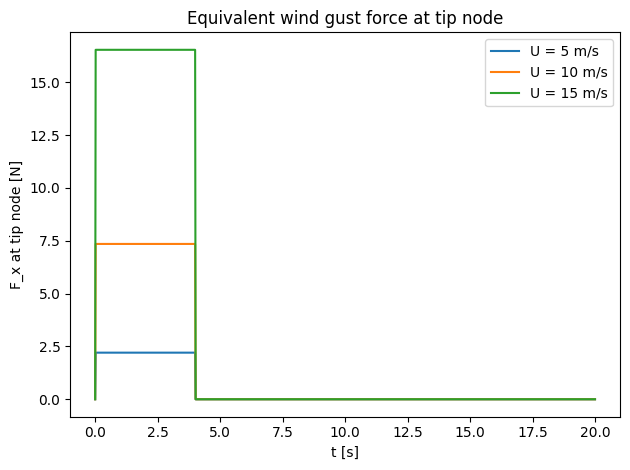

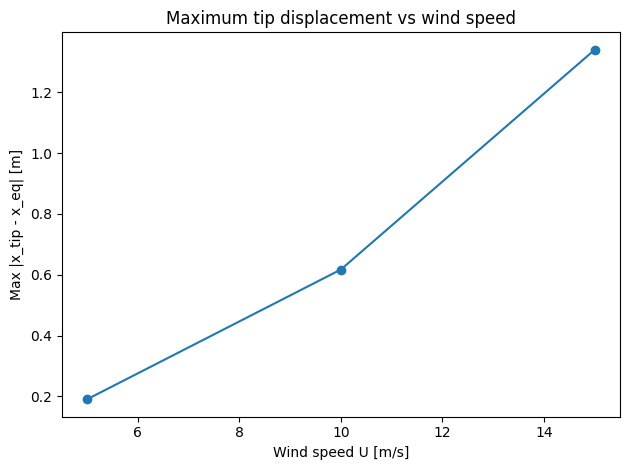

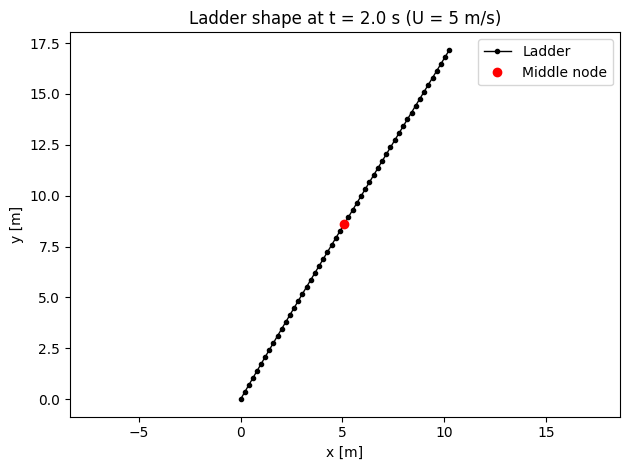

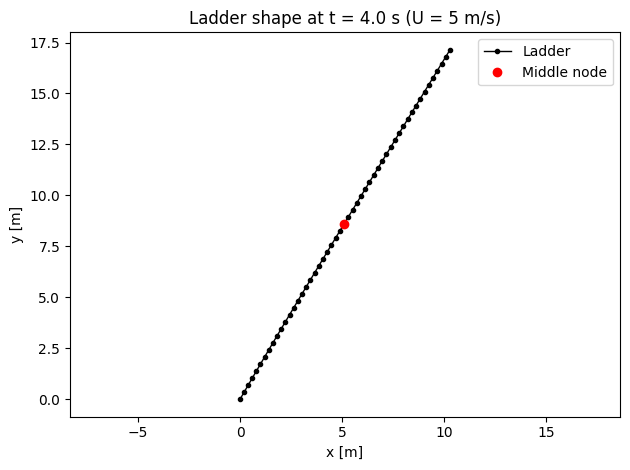

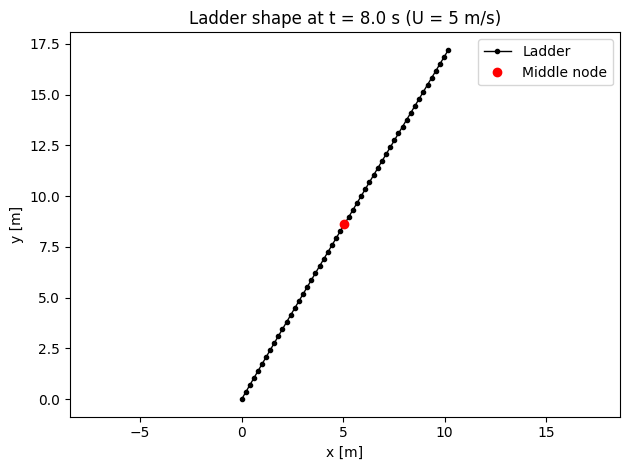

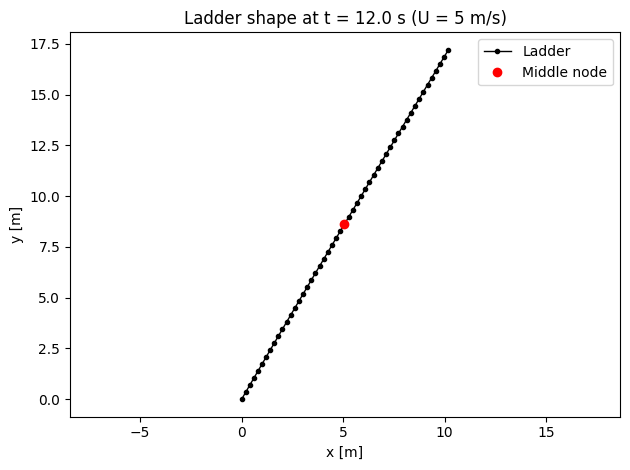

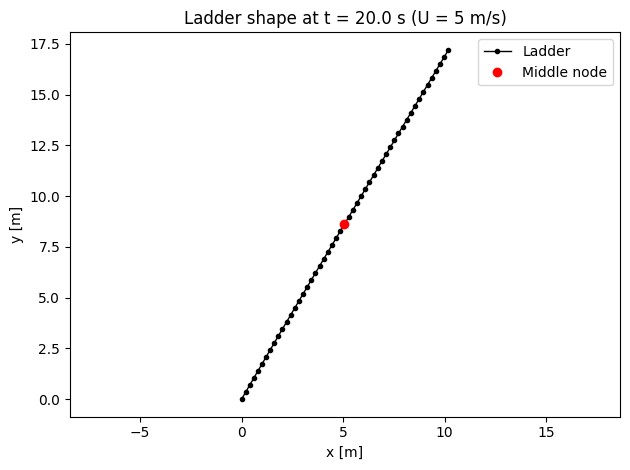

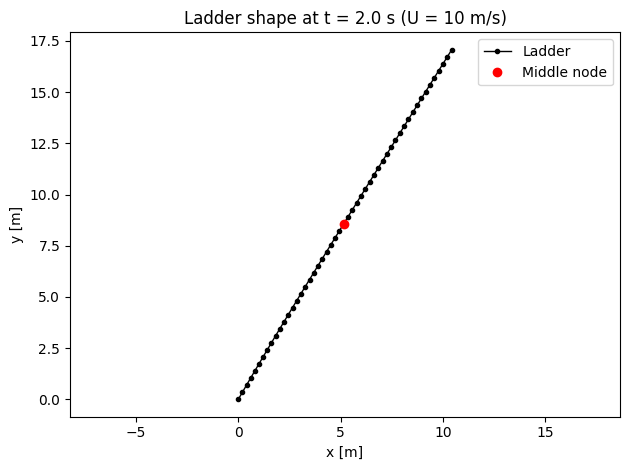

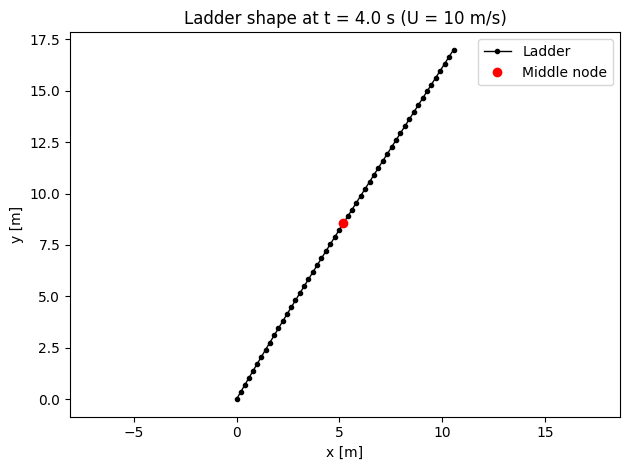

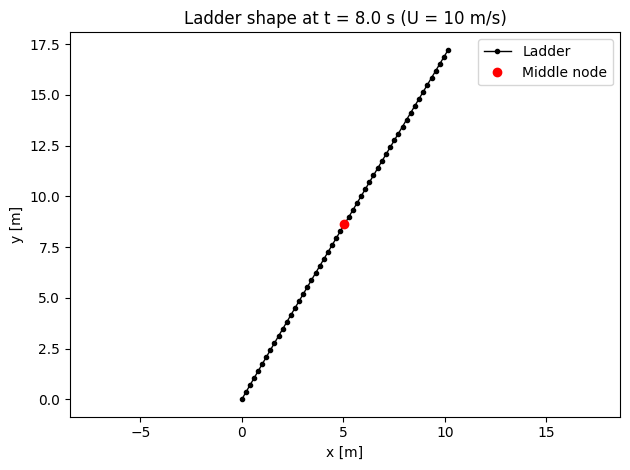

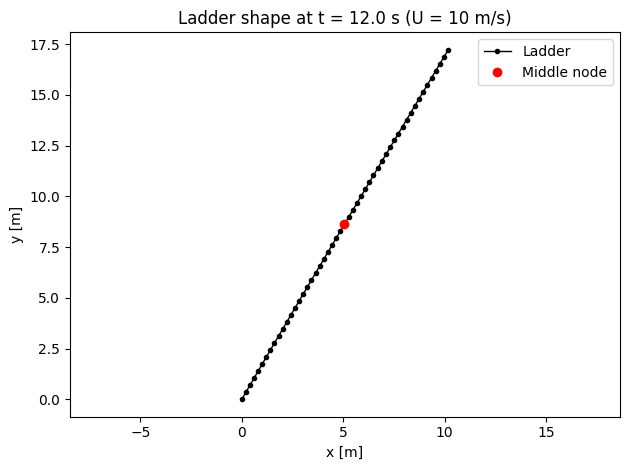

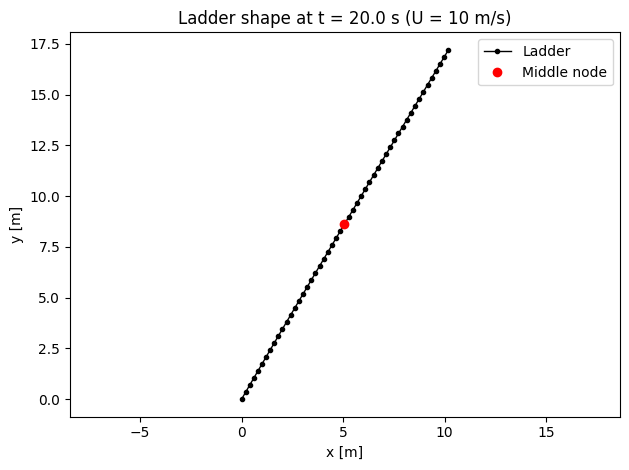

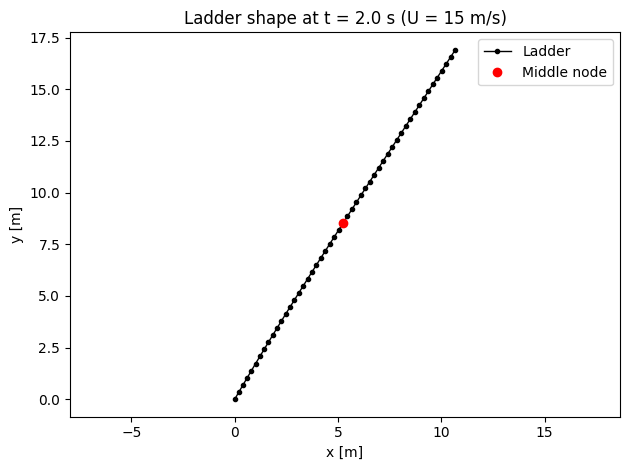

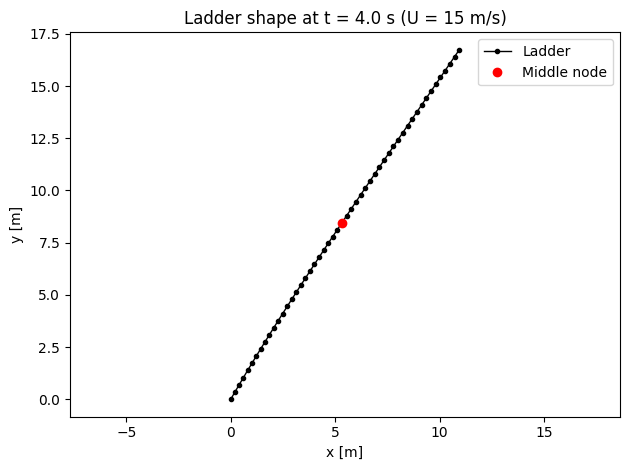

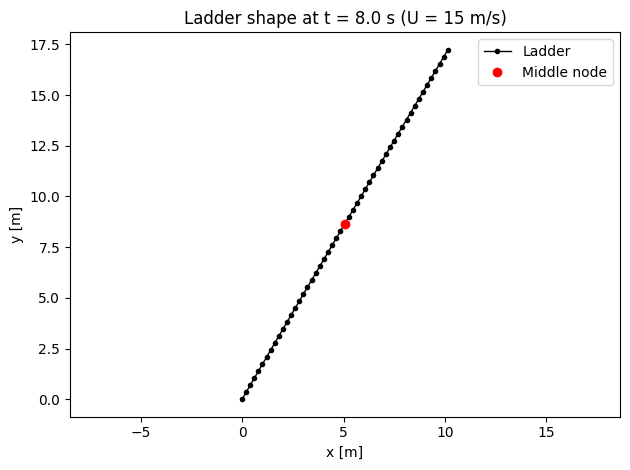

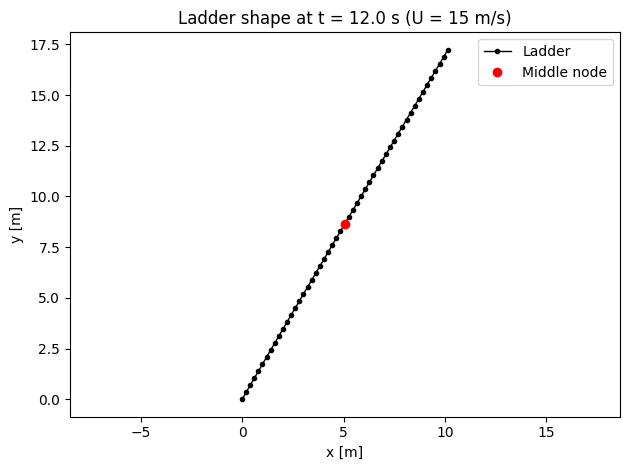

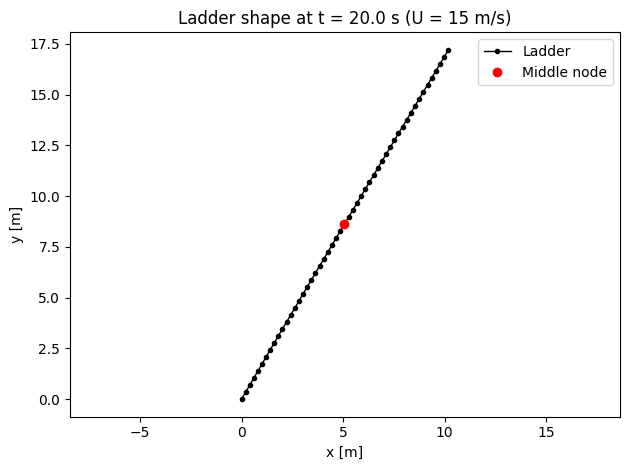

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Utility functions: geometry, masses, wind load
# ============================================================

def build_geometry(nv, RodLength, theta0_rad):
    """
    Build initial straight beam geometry of length RodLength,
    inclined at angle theta0 (w.r.t. x-axis).
    """
    deltaL = RodLength / (nv - 1)
    nodes = np.zeros((nv, 2))
    for c in range(nv):
        s = c * deltaL
        nodes[c, 0] = s * np.cos(theta0_rad)
        nodes[c, 1] = s * np.sin(theta0_rad)
    return nodes, deltaL


def build_masses_and_gravity(nv, R, rho, g_vec):
    """
    Build lumped mass vector, mass matrix, and constant gravity load.
    """
    ndof = 2 * nv
    m = np.zeros(ndof)
    W_gravity = np.zeros(ndof)

    for k in range(nv):
        mass_k = 4.0 / 3.0 * np.pi * R[k]**3 * rho
        m[2 * k]     = mass_k
        m[2 * k + 1] = mass_k
        W_gravity[2 * k]     = mass_k * g_vec[0]
        W_gravity[2 * k + 1] = mass_k * g_vec[1]

    mMat = np.diag(m)
    return m, mMat, W_gravity


def get_base_angle_and_rate(q, u, i0=0, i1=1):
    """
    Compute the angle and angular rate of the segment (i0 -> i1),
    along with its length and a unit normal vector.
    """
    x0, y0 = q[2 * i0],     q[2 * i0 + 1]
    x1, y1 = q[2 * i1],     q[2 * i1 + 1]
    vx0, vy0 = u[2 * i0],   u[2 * i0 + 1]
    vx1, vy1 = u[2 * i1],   u[2 * i1 + 1]

    dx, dy = x1 - x0, y1 - y0
    L = np.hypot(dx, dy)
    if L < 1e-12:
        return 0.0, 0.0, 1.0, (0.0, 1.0)

    ex, ey = dx / L, dy / L
    nx, ny = -ey, ex                # normal
    phi = np.arctan2(dy, dx)

    dvx, dvy = vx1 - vx0, vy1 - vy0
    phi_dot = (dvx * nx + dvy * ny) / L

    return phi, phi_dot, L, (nx, ny)


def torsion_forces_on_base(q, u, phi0, k_theta, c_theta, i0=0, i1=1):
    """
    Torsional spring + damper between nodes i0 and i1:

        M = -k_theta * (phi - phi0) - c_theta * phi_dot
    """
    phi, phi_dot, L, (nx, ny) = get_base_angle_and_rate(q, u, i0, i1)

    M = -k_theta * (phi - phi0) - c_theta * phi_dot
    Fmag = M / L
    F = np.zeros_like(q)

    # Node i0: +F * n
    F[2 * i0]     += Fmag * nx
    F[2 * i0 + 1] += Fmag * ny
    # Node i1: -F * n
    F[2 * i1]     -= Fmag * nx
    F[2 * i1 + 1] -= Fmag * ny

    return F


def compute_wind_drag(U, RodLength, D,
                      rho_air=1.225, mu_air=1.8e-5):
    """
    Given wind speed U [m/s], ladder length L=RodLength [m],
    and characteristic diameter D [m], compute:

    - Reynolds number Re
    - Drag coefficient Cd (piecewise based on Re)
    - Total drag force F_D_total [N]
    - Equivalent distributed load w_dist [N/m]
    """
    Re = rho_air * U * D / mu_air

    # simple piecewise Cd model for a bluff body (ladder-like)
    if Re < 2e5:
        Cd = 1.2
    elif Re < 4e5:
        Cd = 1.0
    else:
        Cd = 0.9

    F_D_total = 0.5 * rho_air * U**2 * Cd * D * RodLength
    w_dist = F_D_total / RodLength   # N/m

    return F_D_total, w_dist, Re, Cd


# ============================================================
# Single-run simulation function (passive base, distributed wind)
# ============================================================

def run_simulation(U,
                   dt=0.02,
                   totalTime=20.0,
                   nv=51,
                   RodLength=20.0,
                   initial_angle_deg=60.0,
                   pre_time=10.0,
                   excitation_duration=4.0):
    """
    Passive ladder under a wind gust:
    - base torsional spring + damper
    - wind treated as distributed horizontal load q(t) along the span
    """
    ndof = 2 * nv
    Nsteps = int(totalTime / dt) + 1

    # ------ geometry ------
    theta0 = np.deg2rad(initial_angle_deg)
    nodes, deltaL = build_geometry(nv, RodLength, theta0)

    # ------ radii & material for lumped masses ------
    R = np.zeros(nv)
    for k in range(nv):
        R[k] = deltaL / 10.0
    midNode = nv // 2
    R[midNode] = 0.025

    # ====== "真实一点"的刚度：EI 约 8e5 N·m²  ======
    E_steel = 70e9  # Pa
    EI_target = 8.0e5
    EI = EI_target
    A_eff = 0.04
    EA = E_steel * A_eff

    maximum_iter = 1000
    tol = 1e-3

    # ------ masses & gravity ------
    rho_metal = 2700.0
    rho = rho_metal
    g_vec = np.array([0.0, -9.8])
    m, mMat, W_gravity = build_masses_and_gravity(nv, R, rho, g_vec)

    # ------ structural damping matrix (Rayleigh mass damping) ------
    alpha_M = 0.001
    C = alpha_M * mMat

    # ------ initial state ------
    q0 = np.zeros(ndof)
    for c in range(nv):
        q0[2 * c]     = nodes[c, 0]
        q0[2 * c + 1] = nodes[c, 1]
    u0 = np.zeros(ndof)

    all_DOFs = np.arange(ndof)
    fixed_index = np.array([0, 1, 2, 3], dtype=int)  # clamp first two nodes
    free_index  = np.setdiff1d(all_DOFs, fixed_index)

    # ------ base torsional spring & damping ------
    phi0 = np.arctan2(nodes[2, 1] - nodes[1, 1],
                      nodes[2, 0] - nodes[1, 0])

    k_theta      = 3e4      # 基座转动刚度
    c_theta_base = 1500.0   # N·m·s/rad

    # ------ wind → distributed load along the ladder ------
    D = 0.30  # [m] effective ladder width
    F_D_total, w_dist, Re, Cd = compute_wind_drag(U, RodLength, D)

    tip_node = nv - 1
    F_tip_node = w_dist * deltaL   # 等效到单个节点的水平力

    print(f"\n=== Wind case U = {U:.1f} m/s ===")
    print(f"Re ≈ {Re:.3e}, Cd ≈ {Cd:.2f}, "
          f"F_D,total ≈ {F_D_total:.1f} N,  w_dist ≈ {w_dist:.1f} N/m")
    print(f"Equivalent nodal force per node ≈ {F_tip_node:.1f} N")

    # ============================================================
    # 1) Pre-settle: gravity only, baseline damping
    # ============================================================
    N_pre = int(pre_time / dt)
    ctime = 0.0

    for _ in range(N_pre):
        F_wind = np.zeros(ndof)
        c_theta = c_theta_base
        F_torsion = torsion_forces_on_base(q0, u0, phi0, k_theta, c_theta,
                                           i0=1, i1=2)

        W_total = W_gravity + F_wind + F_torsion

        q_new, error = objfun(q0, u0, dt, tol, maximum_iter,
                              m, mMat, EI, EA, W_total, C,
                              deltaL, free_index)
        if error < 0:
            print("Pre-settle: did not converge")
            break

        u_new = (q_new - q0) / dt
        q0 = q_new.copy()
        u0 = u_new.copy()
        ctime += dt

    # ===== reset time for main run =====
    ctime = 0.0
    c_theta = c_theta_base

    # ============================================================
    # 2) Main dynamic run
    # ============================================================
    t_arr = np.linspace(0.0, totalTime, Nsteps)
    x_tip_series      = np.zeros(Nsteps)
    theta_base_series = np.zeros(Nsteps)
    c_theta_series    = np.zeros(Nsteps)
    Fx_series         = np.zeros(Nsteps)   # tip 节点的力随时间

    x_tip_series[0]      = q0[2 * tip_node]
    theta_base_series[0] = phi0
    c_theta_series[0]    = c_theta
    Fx_series[0]         = 0.0

    # 想看的 snapshot 时刻：0, 2, 4, 8, 12, totalTime
    snapshot_times = [0.0, 2.0, 4.0, 8.0, 12.0, totalTime]
    snapshots = {}

    for step in range(1, Nsteps):
        t = t_arr[step]

        # ---- wind gust only during excitation_duration ----
        F_wind = np.zeros(ndof)
        if ctime <= excitation_duration:
            # 从第 2 个节点到 tip，沿 x 方向均布
            for k in range(2, nv):
                F_wind[2 * k] += w_dist * deltaL
            Fx_tip = w_dist * deltaL    # tip 节点大小
        else:
            Fx_tip = 0.0

        # ---- base angle & angular rate ----
        phi_curr, phi_dot, _, _ = get_base_angle_and_rate(q0, u0, i0=1, i1=2)

        # passive damping is constant
        c_theta = c_theta_base

        # ----- torsional force at base -----
        F_torsion = torsion_forces_on_base(q0, u0, phi0, k_theta, c_theta,
                                           i0=1, i1=2)

        # ---- total external force ----
        W_total = W_gravity + F_wind + F_torsion

        # ---- implicit step ----
        q_new, error = objfun(q0, u0, dt, tol, maximum_iter,
                              m, mMat, EI, EA, W_total, C,
                              deltaL, free_index)
        if error < 0:
            print(f"Simulation (U={U:.1f}) did not converge at t = {ctime:.3f} s")
            break

        u_new = (q_new - q0) / dt
        ctime += dt

        # ---- record history ----
        x_arr = q_new[::2]
        y_arr = q_new[1::2]

        x_tip_series[step]      = x_arr[tip_node]
        theta_base_series[step] = phi_curr
        c_theta_series[step]    = c_theta
        Fx_series[step]         = Fx_tip

        # 在若干指定时刻保存形状（更稳的判断方式）
        for t_snap in snapshot_times:
            if (t_snap not in snapshots) and (abs(ctime - t_snap) <= 0.5 * dt):
                snapshots[t_snap] = (x_arr.copy(), y_arr.copy())

        q0 = q_new.copy()
        u0 = u_new.copy()

    result = {
        "U": U,
        "Re": Re,
        "Cd": Cd,
        "t_arr": t_arr,
        "x_tip": x_tip_series,
        "theta_base": theta_base_series,
        "c_theta": c_theta_series,
        "Fx_tip": Fx_series,
        "snapshots": snapshots,
        "nodes_init": nodes,
        "midNode": midNode,
    }
    return result


# ============================================================
# Main script: run three wind-speed cases, plot
# ============================================================

if __name__ == "__main__":
    dt = 0.02
    totalTime = 20.0
    nv = 51
    RodLength = 20.0
    initial_angle_deg = 60.0

    # 3 wind speeds: 5 / 10 / 15 m/s
    U_list = [5.0, 10.0, 15.0]

    results = {}
    for U in U_list:
        print(f"\nRunning passive simulation for U = {U} m/s ...")
        results[U] = run_simulation(
            U=U,
            dt=dt,
            totalTime=totalTime,
            nv=nv,
            RodLength=RodLength,
            initial_angle_deg=initial_angle_deg
        )

    # ------------- Plot: tip horizontal displacement vs time -------------
    plt.figure()
    for U in U_list:
        res = results[U]
        t_arr = res["t_arr"]
        label = f"U = {U:.0f} m/s (Re≈{res['Re']:.1e})"
        plt.plot(t_arr, res["x_tip"], label=label)
    plt.xlabel("t [s]")
    plt.ylabel("Tip x-displacement [m]")
    plt.title("Tip horizontal displacement vs time for different wind speeds")
    plt.legend()
    plt.tight_layout()

    # ------------- Plot: base angle vs time -------------
    plt.figure()
    for U in U_list:
        res = results[U]
        t_arr = res["t_arr"]
        plt.plot(t_arr, res["theta_base"], label=f"U = {U:.0f} m/s")
    plt.xlabel("t [s]")
    plt.ylabel("Base angle φ(t) [rad]")
    plt.title("Base segment angle vs time for different wind speeds")
    plt.legend()
    plt.tight_layout()

    # ------------- Plot: tip force time history -------------
    plt.figure()
    for U in U_list:
        res = results[U]
        t_arr = res["t_arr"]
        plt.plot(t_arr, res["Fx_tip"], label=f"U = {U:.0f} m/s")
    plt.xlabel("t [s]")
    plt.ylabel("F_x at tip node [N]")
    plt.title("Equivalent wind gust force at tip node")
    plt.legend()
    plt.tight_layout()

    # ------------- NEW: Max tip displacement vs wind speed -------------
    U_vals = []
    xmax_vals = []
    for U in U_list:
        res = results[U]
        t_arr = res["t_arr"]
        x = res["x_tip"]
        # 取后 5 秒的平均作为“平衡位置”
        idx_eq = int((totalTime - 5.0) / dt)
        x_eq = np.mean(x[idx_eq:])
        xmax = np.max(np.abs(x - x_eq))
        U_vals.append(U)
        xmax_vals.append(xmax)

    plt.figure()
    plt.plot(U_vals, xmax_vals, "o-")
    plt.xlabel("Wind speed U [m/s]")
    plt.ylabel("Max |x_tip - x_eq| [m]")
    plt.title("Maximum tip displacement vs wind speed")
    plt.tight_layout()

        # ------------- Ladder shape snapshots for all wind speeds -------------
    for U in U_list:
        resU = results[U]
        snapshots = resU["snapshots"]
        mid_idx   = resU["midNode"]

        for t_snap in sorted(snapshots.keys()):
            xa, ya = snapshots[t_snap]
            plt.figure()
            plt.plot(xa, ya, "k.-", linewidth=1, label="Ladder")
            plt.plot(xa[mid_idx], ya[mid_idx], "ro", markersize=6,
                     label="Middle node")
            plt.axis("equal")
            plt.xlabel("x [m]")
            plt.ylabel("y [m]")
            plt.title(f"Ladder shape at t = {t_snap:.1f} s (U = {U:.0f} m/s)")
            plt.legend()
            plt.tight_layout()


    plt.show()
